In [10]:
import pandas as pd
import os.path
import numpy as np
import datetime as dt
import smogn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
import sklearn.metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Data preparation
#### Download data

In [11]:
stations = ["BELRL01", "BETR001", "BETR501"]
df_dict = {}
for stat in stations:
    df_dict[stat] = pd.read_csv(os.path.join("data",f"{stat}_daily.csv"), index_col=0, header=0)
    print(df_dict[stat].columns)

Index(['PM10', 'blh', 'sp', 'mcc', 'd2m', 't2m', 'w_speed', 'w_dir', 'DoW',
       'PM2.5_morning', 'PM10_morning'],
      dtype='object')
Index(['PM10', 'mcc', 'sp', 't2m', 'blh', 'd2m', 'w_speed', 'w_dir', 'DoW',
       'SO2_morning', 'NO2_morning', 'CO_morning', 'O3_morning',
       'PM2.5_morning', 'PM10_morning'],
      dtype='object')
Index(['PM10', 'surface', 't2m', 'blh', 'mcc', 'sp', 'd2m', 'w_speed', 'w_dir',
       'DoW', 'NO2_morning', 'CO_morning', 'PM2.5_morning', 'PM10_morning'],
      dtype='object')


#### Preparing datasets + Resampling

In [4]:
test_size=0.1

varset1 = ['PM10_morning','blh']
varset2 = varset1+['mcc','w_dir','DoW']
#varset3 = varset2+['w_speed']
#varset4 = varset3+['SO2_morning', 'NO2_morning', 'CO_morning', 'O3_morning']
varsets = [varset1,varset2]


stat_dict = {}
for stat,df_daily in df_dict.items():
    print(f'Station: {stat}')
    X_trainsets = []
    X_trainsets_smogn = []
    Y_trainsets = []
    Y_trainsets_smogn = []
    X_testsets = []
    Y_testsets = []
    scalers = []
    for varset in varsets:
        df = df_daily[varset+["PM10"]].dropna()
        df_train, df_test = train_test_split(df, test_size=test_size, random_state=1, shuffle=True)
        df_train.dropna(inplace=True)
        df_train_smogn = smogn.smoter(data=df_train.reset_index(drop=True), y="PM10")
        #print(len(df_train[df_train["PM10"]>50]))
        #print(len(df_train_smogn[df_train_smogn["PM10"]>50]))
        X_train = df_train[varset]
        X_train_smogn = df_train_smogn[varset]
        X_test = df_test[varset]
        sc_X = StandardScaler()
        X_trainsets.append(sc_X.fit_transform(X_train.values))
        X_trainsets_smogn.append(sc_X.transform(X_train_smogn.values))
        X_testsets.append(sc_X.transform(X_test.values))
        scalers.append(sc_X)
        Y_trainsets.append(df_train["PM10"].values.reshape(-1,1))
        Y_trainsets_smogn.append(df_train_smogn["PM10"].values.reshape(-1,1))
        Y_testsets.append(df_test["PM10"].values.reshape(-1,1))
    data_dict={}
    data_dict["Xtr"] = X_trainsets
    data_dict["Ytr"] = Y_trainsets
    data_dict["Xtr_smogn"] = X_trainsets_smogn
    data_dict["Ytr_smogn"] = Y_trainsets_smogn
    data_dict["Xte"] = X_testsets
    data_dict["Yte"] = Y_testsets
    data_dict["scalers"] = scalers
    stat_dict[stat] = data_dict

Station: BELRL01


r_index: 100%|##########| 5/5 [00:00<00:00, 633.39it/s]


Station: BETR001


r_index: 100%|##########| 123/123 [00:00<00:00, 687.12it/s]


Station: BETR501


r_index: 100%|##########| 244/244 [00:00<00:00, 647.46it/s]


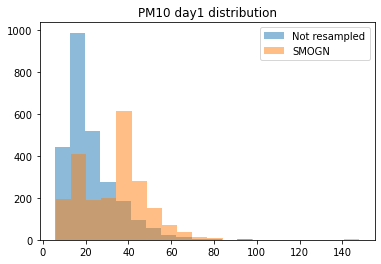

In [45]:
stat_dict["BELRL01"].keys()
plt.title("PM10 day1 distribution")
plt.hist(stat_dict["BELRL01"]["Ytr"][1], bins=20, alpha=0.5, label="Not resampled")
plt.hist(stat_dict["BELRL01"]["Ytr_smogn"][1], bins=20, alpha=0.5, label="SMOGN")
plt.legend()
plt.show()

In [13]:
def successIndex(Y, Y_pred, threshold=50):
        Y = Y.flatten()
        Y_pred = Y_pred.flatten()
        NOF = np.count_nonzero((Y>threshold) & (Y_pred>threshold))
        NOF_ = np.count_nonzero((Y>threshold) & (Y_pred<=threshold))
        NO_F = np.count_nonzero((Y<=threshold) & (Y_pred>threshold))
        NO_F_ = np.count_nonzero((Y<=threshold) & (Y_pred<=threshold))
        #print(NOF, NOF_, NO_F, NO_F_)
        if (NOF+NOF_)==0 or NO_F_+NO_F==0:
            return float('NaN')
        si = 100*(NOF/(NOF+NOF_) + NO_F_/(NO_F_+NO_F)-1)
        return si

### Persistence model

In [14]:
scX = stat_dict[stat]['scalers'][0]
persistence_RMSE = [np.sqrt(np.mean((scX.inverse_transform(stat_dict[stat]['Xtr'][0])[:,0]-stat_dict[stat]['Ytr'][0])**2)) for stat in stations]
persistence_SI = [successIndex(scX.inverse_transform(stat_dict[stat]['Xtr'][0])[:,0], stat_dict[stat]['Ytr'][0], threshold=50) for stat in stations]


print('\t'+'\t'.join(stat for stat in stations))
print('RMSE:\t'+'\t'.join(f'{m:.2f}' for m in persistence_RMSE))
print('SI:\t'+'\t'.join(f'{m:.2f}' for m in persistence_SI))


	BELRL01	BETR001	BETR501
RMSE:	19.56	19.49	20.70
SI:	21.22	23.08	25.05


### Neural network

In [37]:
def baseline_model():
    model = keras.Sequential()
    model.add(layers.Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
estimator1 = KerasRegressor(build_fn=baseline_model,
                            epochs=50,
                            batch_size=5,
                            verbose=0,
                            validation_split=0.1,
                            callbacks=[es])

kfold = KFold(n_splits=5)
scoring = {'MSE': make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False),
            'SI_50': make_scorer(successIndex, threshold=50, greater_is_better=True)}

/var/folders/zz/3tv31pz94s124657mcj6j30w0000gn/T/ipykernel_54944/1637662708.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator1 = KerasRegressor(build_fn=baseline_model,


In [38]:
for stat, data_dict in stat_dict.items():
    print(f"Training on {stat} data")
    X_trainsets = data_dict["Xtr"]
    X_trainsets_smogn = data_dict["Xtr_smogn"]
    Y_trainsets = data_dict["Ytr"]
    Y_trainsets_smogn = data_dict["Ytr_smogn"]
    X_testsets = data_dict["Xte"]
    Y_testsets = data_dict["Yte"]

    results = []
    print("Regular training data")
    for i, (X_trainset, Y_trainset) in enumerate(zip(X_trainsets, Y_trainsets)):
        print(f"\tVariable set {i+1}, {np.shape(X_trainset)[1]} input variables")
        cv_res = cross_validate(estimator1, X_trainset, Y_trainset, cv=kfold, scoring=scoring, verbose=1)
        results.append(cv_res)
        print(f'\t\tMSE: {cv_res["test_MSE"]}')
        print(f'\t\tSI: {cv_res["test_SI_50"]}')
    stat_dict[stat]["CV_results"] = results

    results_smogn = []
    print("SMOGN training data")
    for i, (X_trainset_smogn, Y_trainset_smogn) in enumerate(zip(X_trainsets_smogn, Y_trainsets_smogn)):
        print(f"\tVariable set {i+1}, {np.shape(X_trainset_smogn)[1]} input variables")
        cv_res_smogn = cross_validate(estimator1, X_trainset_smogn, Y_trainset_smogn, cv=kfold, scoring=scoring, verbose=1)
        results_smogn.append(cv_res_smogn)
        print(f'\t\tMSE - smogn: {cv_res_smogn["test_MSE"]}')
        print(f'\t\tSI -smogn: {cv_res_smogn["test_SI_50"]}')
    stat_dict[stat]["CV_results_smogn"] = results_smogn

Training on BELRL01 data
Regular training data
	Variable set 1, 2 input variables


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00039: early stopping
Epoch 00022: early stopping
Epoch 00048: early stopping
Epoch 00043: early stopping
Epoch 00032: early stopping
		MSE: [-70.38666023 -71.98518341 -76.57576463 -66.59667614 -74.41938138]
		SI: [ 4.66554833  4.86475152 11.11111111 10.32671499  6.0515873 ]
	Variable set 2, 5 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00046: early stopping
Epoch 00042: early stopping
Epoch 00024: early stopping
		MSE: [-69.1505356  -66.5445192  -72.1524536  -60.52961208 -77.85676708]
		SI: [ 4.46634515  4.86475152 16.66666667 10.32671499  6.0515873 ]
SMOGN training data
	Variable set 1, 2 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00038: early stopping
Epoch 00028: early stopping
Epoch 00027: early stopping
Epoch 00021: early stopping
Epoch 00020: early stopping
		MSE - smogn: [ -76.89376963 -249.42653288 -118.84961816 -141.22044301 -125.2376964 ]
		SI -smogn: [-5.99078341  6.65584416 10.3630363  23.75621891  4.6743295 ]
	Variable set 2, 5 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00040: early stopping
Epoch 00034: early stopping
Epoch 00041: early stopping
Epoch 00021: early stopping
Epoch 00019: early stopping
		MSE - smogn: [ -66.8126276  -262.7647882  -121.1322936  -128.6663766  -117.88847499]
		SI -smogn: [        nan  3.71732026 16.49212431 22.09570957 10.50995025]
Training on BETR001 data
Regular training data
	Variable set 1, 2 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00027: early stopping
Epoch 00030: early stopping
Epoch 00004: early stopping
Epoch 00037: early stopping
Epoch 00027: early stopping
		MSE: [ -66.67515627  -64.14907934 -617.84767462  -70.35982732  -73.72826568]
		SI: [18.13398357 14.28571429  0.          0.          7.14285714]
	Variable set 2, 5 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00042: early stopping
Epoch 00040: early stopping
Epoch 00037: early stopping
Epoch 00033: early stopping
Epoch 00021: early stopping
		MSE: [-55.20548049 -52.93704383 -64.56364729 -59.53746397 -64.07202612]
		SI: [24.38398357 14.28571429  5.43715847  8.12966735  7.14285714]
SMOGN training data
	Variable set 1, 2 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00023: early stopping
Epoch 00004: early stopping
Epoch 00017: early stopping
Epoch 00004: early stopping
Epoch 00022: early stopping
		MSE - smogn: [  -77.11399808 -2342.59295955  -109.97037353  -864.5751522
  -102.67917397]
		SI -smogn: [-6.55737705  0.         33.9556962   0.         12.80788177]
	Variable set 2, 5 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00029: early stopping
Epoch 00017: early stopping
Epoch 00018: early stopping
Epoch 00018: early stopping
Epoch 00021: early stopping
		MSE - smogn: [ -73.45111967 -197.19192343  -88.61056297 -104.84627155  -95.05970395]
		SI -smogn: [        nan 10.19166019 40.86836103 18.02625915 17.0771757 ]
Training on BETR501 data
Regular training data
	Variable set 1, 2 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00015: early stopping
Epoch 00012: early stopping
Epoch 00045: early stopping
		MSE: [ -89.45023138  -92.05821309  -95.42123954  -90.55251774 -105.38347979]
		SI: [ 9.09090909  4.56230396 11.79879276  3.94621966 11.53846154]
	Variable set 2, 5 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00042: early stopping
Epoch 00049: early stopping
Epoch 00030: early stopping
		MSE: [-71.36630495 -74.21646084 -77.28717918 -68.19487241 -85.36799344]
		SI: [ 8.89090909 -0.3992016  23.59758551 -0.40160643 23.07692308]
SMOGN training data
	Variable set 1, 2 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00018: early stopping
Epoch 00014: early stopping
Epoch 00015: early stopping
Epoch 00017: early stopping
Epoch 00016: early stopping
		MSE - smogn: [-105.40888117 -235.03544697 -133.97549139 -145.14035785 -159.19674497]
		SI -smogn: [17.07060063 14.60471567 28.10195913 44.14634146 46.85400806]
	Variable set 2, 5 input variables


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00025: early stopping
Epoch 00016: early stopping
Epoch 00018: early stopping
Epoch 00015: early stopping
Epoch 00018: early stopping
		MSE - smogn: [-102.16697098 -217.87864565 -117.98306625 -122.67400936 -135.52829703]
		SI -smogn: [10.02267574 13.53233831 23.90243902 46.26848294 55.0617284 ]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.6s finished


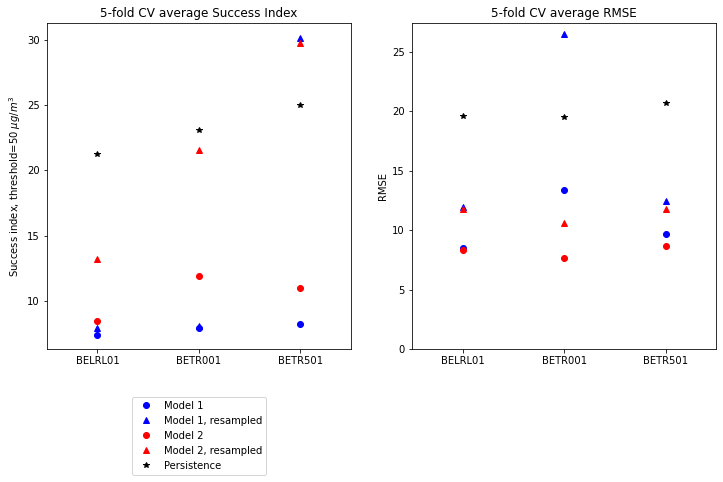

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot([np.nanmean(stat_dict[stat]['CV_results'][0]['test_SI_50']) for stat in stations],
        "bo", label='Model 1')
plt.plot([np.nanmean(stat_dict[stat]['CV_results_smogn'][0]['test_SI_50']) for stat in stations],
        "b^", label='Model 1, resampled')
plt.plot([np.nanmean(stat_dict[stat]['CV_results'][1]['test_SI_50']) for stat in stations],
        "ro", label='Model 2')
plt.plot([np.nanmean(stat_dict[stat]['CV_results_smogn'][1]['test_SI_50']) for stat in stations],
        "r^", label='Model 2, resampled')
plt.plot(persistence_SI, "k*", label='Persistence')
plt.xticks(ticks=[0,1,2], labels=stations)
plt.xlim([-0.5,2.5])
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
plt.ylabel(r"Success index, threshold=$50$ $\mu g/m^3$")
plt.title("5-fold CV average Success Index")


plt.subplot(1, 2, 2)
plt.plot([np.sqrt(np.mean(-stat_dict[stat]['CV_results'][0]['test_MSE'])) for stat in stations], "bo")
plt.plot([np.sqrt(np.mean(-stat_dict[stat]['CV_results'][1]['test_MSE'])) for stat in stations], "ro")
plt.plot([np.sqrt(np.mean(-stat_dict[stat]['CV_results_smogn'][0]['test_MSE'])) for stat in stations], "b^")
plt.plot([np.sqrt(np.mean(-stat_dict[stat]['CV_results_smogn'][1]['test_MSE'])) for stat in stations], "r^")
plt.plot(persistence_RMSE, "k*", label='Persistence')
plt.ylabel("RMSE")
plt.ylim(bottom=0)
plt.xlim([-0.5,2.5])
plt.xticks(ticks=[0,1,2], labels=stations)
plt.title("5-fold CV average RMSE")
plt.show()

## SVM

In [41]:
K=5
kfold = KFold(n_splits=K)
scoring = {'NMSE': "neg_mean_squared_error",
            'SI_50': make_scorer(successIndex, threshold=50)}
parameters = [{'kernel': ['rbf'], 
                'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                'C': [1, 10, 100, 1000],
                'epsilon': [0.001, 0.01, 0.1]}]
                
for stat, data_dict in stat_dict.items():
    print(f"Training on {stat} data")
    X_trainsets = data_dict["Xtr"]
    X_trainsets_smogn = data_dict["Xtr_smogn"]
    Y_trainsets = data_dict["Ytr"]
    Y_trainsets_smogn = data_dict["Ytr_smogn"]
    X_testsets = data_dict["Xte"]
    Y_testsets = data_dict["Yte"]
    
    print("regular training data")
    results = []
    for i, (X_trainset, Y_trainset) in enumerate(zip(X_trainsets, Y_trainsets)):
        print(f"\tVariable set {i+1}, {np.shape(X_trainset)[1]} input variables")
        grid = GridSearchCV(SVR(),
                            parameters,
                            cv = K,
                            scoring="neg_mean_squared_error",
                            verbose=1,
                            refit=True)
        grid.fit(X_trainset, Y_trainset.flatten())
        cv_res = cross_validate(grid.best_estimator_,
                X_trainset, np.ravel(Y_trainset),
                cv=kfold, scoring=scoring, verbose=0)
        print("\tNMSE: ",cv_res['test_NMSE'])
        print("\tSI: ",cv_res['test_SI_50'])
        results.append(cv_res)
    stat_dict[stat]["SVM_results"] = results


    print("SMOGN training data")
    results_smogn = []
    for i, (X_trainset_smogn, Y_trainset_smogn) in enumerate(zip(X_trainsets_smogn, Y_trainsets_smogn)):
        print(f"\tVariable set {i+1}, {np.shape(X_trainset_smogn)[1]} input variables")
        grid = GridSearchCV(SVR(),
                            parameters,
                            cv = K,
                            scoring="neg_mean_squared_error",
                            verbose=1,
                            refit=True)
        grid.fit(X_trainset_smogn, Y_trainset_smogn.flatten())
        cv_res = cross_validate(grid.best_estimator_,
                X_trainset_smogn, np.ravel(Y_trainset_smogn),
                cv=kfold, scoring=scoring, verbose=0)
        print("\tNMSE: ",cv_res['test_NMSE'])
        print("\tSI: ",cv_res['test_SI_50'])
        results_smogn.append(cv_res)
    stat_dict[stat]["SVM_results_smogn"] = results_smogn
    


Training on BELRL01 data
regular training data
	Variable set 1, 2 input variables
Fitting 5 folds for each of 72 candidates, totalling 360 fits
	NMSE:  [-67.95621515 -65.18291452 -74.69222945 -68.80331608 -73.82905833]
	SI:  [ 9.72950304  5.06395471 11.11111111 -0.1996008   6.0515873 ]
	Variable set 2, 5 input variables
Fitting 5 folds for each of 72 candidates, totalling 360 fits
	NMSE:  [-61.1124323  -59.87218758 -68.47697543 -58.94641996 -66.8055347 ]
	SI:  [15.19186412  5.06395471  5.3567484  10.12711419 -0.3968254 ]
SMOGN training data
	Variable set 1, 2 input variables
Fitting 5 folds for each of 72 candidates, totalling 360 fits
	NMSE:  [ -84.07420331 -266.14292656  -98.32288268 -126.59398823 -101.18119682]
	SI:  [-6.22119816  0.          3.33333333  0.          0.        ]
	Variable set 2, 5 input variables
Fitting 5 folds for each of 72 candidates, totalling 360 fits
	NMSE:  [ -74.96466284 -270.12233708  -94.67204785 -118.89873569  -92.42275976]
	SI:  [       nan 0.         9.

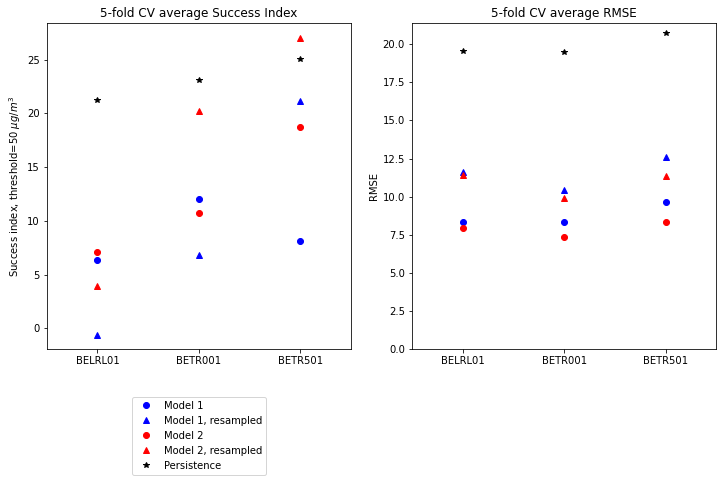

In [42]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("5-fold CV average Success Index")
plt.plot([np.nanmean(stat_dict[stat]['SVM_results'][0]['test_SI_50']) for stat in stations],
        "bo", label='Model 1')
plt.plot([np.nanmean(stat_dict[stat]['SVM_results_smogn'][0]['test_SI_50']) for stat in stations],
        "b^", label='Model 1, resampled')
plt.plot([np.nanmean(stat_dict[stat]['SVM_results'][1]['test_SI_50']) for stat in stations],
        "ro", label='Model 2')
plt.plot([np.nanmean(stat_dict[stat]['SVM_results_smogn'][1]['test_SI_50']) for stat in stations],
        "r^", label='Model 2, resampled')
plt.plot(persistence_SI, "k*", label='Persistence')
plt.xticks(ticks=[0,1,2], labels=stations)
plt.xlim([-0.5,2.5])
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
plt.ylabel(r"Success index, threshold=$50$ $\mu g/m^3$")



plt.subplot(1, 2, 2)
plt.title("5-fold CV average RMSE")
plt.plot([np.sqrt(np.mean(-stat_dict[stat]['SVM_results'][0]['test_NMSE'])) for stat in stations], "bo")
plt.plot([np.sqrt(np.mean(-stat_dict[stat]['SVM_results'][1]['test_NMSE'])) for stat in stations], "ro")
plt.plot([np.sqrt(np.mean(-stat_dict[stat]['SVM_results_smogn'][0]['test_NMSE'])) for stat in stations], "b^")
plt.plot([np.sqrt(np.mean(-stat_dict[stat]['SVM_results_smogn'][1]['test_NMSE'])) for stat in stations], "r^")
plt.plot(persistence_RMSE, "k*", label='Persistence')
plt.ylabel("RMSE")
plt.ylim(bottom=0)
plt.xlim([-0.5,2.5])
plt.xticks(ticks=[0,1,2], labels=stations)
plt.show()

In [435]:
splitKeys_NMSE = [f"split{i}_test_NMSE" for i in range(5)]
splitKeys_SI_50 = [f"split{i}_test_NMSE" for i in range(5)]


SVM_results = {}
for stat in stations:
    print(f'Station: {stat}')
    SVM_results[stat] = {}
    argm = [np.argmax(svm_res['mean_test_NMSE']) for svm_res in stat_dict[stat]['SVM_results']]
    argm_smogn = [np.argmax(svm_res['mean_test_NMSE']) for svm_res in stat_dict[stat]['SVM_results_smogn']]
    rmse = []
    si = []
    rmse_smogn = []
    si_smogn = []
    for i in range(len(argm)):
        print(f'\tVariable set {i}')
        print(f'\tParameters: {stat_dict[stat]["SVM_results"][i]["params"][argm[i]]}')
        MSE_folds = [-stat_dict[stat]['SVM_results'][i][key][argm[i]] for key in splitKeys_NMSE]
        SI_folds = [stat_dict[stat]['SVM_results'][i][key][argm[i]] for key in splitKeys_SI_50]
        rmse.append(np.sqrt(np.mean(MSE_folds)))
        si.append(np.mean(SI_folds))
        MSE_folds_smogn = [-stat_dict[stat]['SVM_results_smogn'][i][key][argm_smogn[i]] for key in splitKeys_NMSE]
        SI_folds_smogn = [stat_dict[stat]['SVM_results_smogn'][i][key][argm_smogn[i]] for key in splitKeys_SI_50]
        rmse_smogn.append(np.sqrt(np.mean(MSE_folds_smogn)))
        si_smogn.append(np.mean(SI_folds_smogn))
    SVM_results[stat]['RMSE'] = rmse
    SVM_results[stat]['SI'] = si
    SVM_results[stat]['RMSE_smogn'] = rmse_smogn
    SVM_results[stat]['SI_smogn'] = si_smogn

print(SVM_results)

    

Station: BELRL01
	Variable set 0
	Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
	Variable set 1
	Parameters: {'C': 1000, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Station: BETR001
	Variable set 0
	Parameters: {'C': 1000, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
	Variable set 1
	Parameters: {'C': 1000, 'epsilon': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
Station: BETR501
	Variable set 0
	Parameters: {'C': 1000, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
	Variable set 1
	Parameters: {'C': 1000, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
{'BELRL01': {'RMSE': [8.37214110637214, 7.939943954076359], 'SI': [-70.09274670500612, -63.04270999387372], 'RMSE_smogn': [11.863132549209993, 11.254006198006365], 'SI_smogn': [-140.7339138801256, -126.65265550476568]}, 'BETR001': {'RMSE': [8.309876907740206, 7.350136195582784], 'SI': [-69.05405422179392, -54.024502093616164], 'RMSE_smogn': [10.624162620438268, 9.696609962918988], 'SI_smogn': [-112.8728313855177

In [429]:
stat = 'BELRL01'
argm = [np.argmax(svm_res['mean_test_NMSE']) for svm_res in stat_dict[stat]['SVM_results']]
Xtrain = stat_dict[stat]['Xtr'][1]
Ytrain = stat_dict[stat]['Ytr'][1]
params = stat_dict[stat]["SVM_results"][1]["params"][argm[1]]
svr_opt = SVR(**params)
kfold = KFold(n_splits=5)
scoring = {'NMSE': "neg_mean_squared_error",
            'SI_50': make_scorer(successIndex, threshold=50)}
cv_res_smogn = cross_validate(svr_opt, Xtrain, Ytrain, cv=kfold, scoring=scoring, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/Caskroom/miniconda/base/envs/PM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/PM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/PM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/PM/lib/python3.8/s

In [430]:
cv_res_smogn

{'fit_time': array([0.47426581, 0.50013614, 0.45901418, 0.49288607, 0.50319004]),
 'score_time': array([0.1365931 , 0.14271903, 0.12667871, 0.1313231 , 0.12452197]),
 'test_NMSE': array([-61.1124323 , -59.87218758, -68.47697543, -58.94641996,
        -66.8055347 ]),
 'test_SI_50': array([15.19186412,  5.06395471,  5.3567484 , 10.12711419, -0.3968254 ])}

## Results

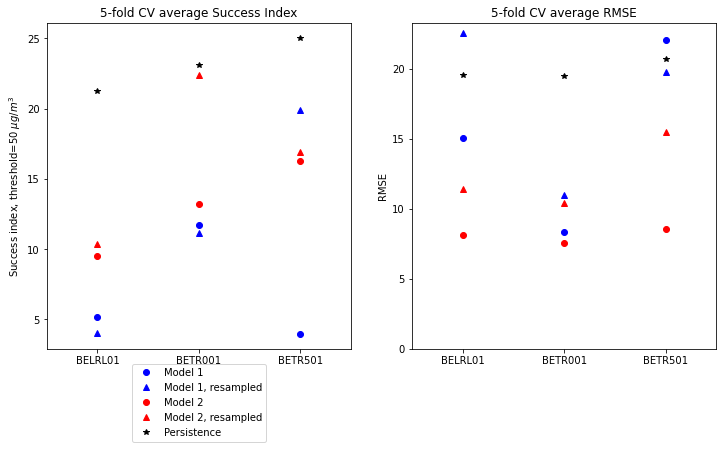

In [365]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot([np.nanmean(stat_dict[stat]['CV_results'][0]['test_SI_50']) for stat in stations],
        "bo", label='Model 1')
plt.plot([np.nanmean(stat_dict[stat]['CV_results_smogn'][0]['test_SI_50']) for stat in stations],
        "b^", label='Model 1, resampled')
plt.plot([np.nanmean(stat_dict[stat]['CV_results'][1]['test_SI_50']) for stat in stations],
        "ro", label='Model 2')
plt.plot([np.nanmean(stat_dict[stat]['CV_results_smogn'][1]['test_SI_50']) for stat in stations],
        "r^", label='Model 2, resampled')
plt.plot(persistence_SI, "k*", label='Persistence')
plt.xticks(ticks=[0,1,2], labels=stations)
plt.xlim([-0.5,2.5])
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))
plt.ylabel(r"Success index, threshold=$50$ $\mu g/m^3$")
plt.title("5-fold CV average Success Index")


plt.subplot(1, 2, 2)
plt.plot([np.mean(-stat_dict[stat]['CV_results'][0]['test_RMSE']) for stat in stations], "bo")
plt.plot([np.mean(-stat_dict[stat]['CV_results'][1]['test_RMSE']) for stat in stations], "ro")
plt.plot([np.mean(-stat_dict[stat]['CV_results_smogn'][0]['test_RMSE']) for stat in stations], "b^")
plt.plot([np.mean(-stat_dict[stat]['CV_results_smogn'][1]['test_RMSE']) for stat in stations], "r^")
plt.plot(persistence_RMSE, "k*", label='Persistence')
plt.ylabel("RMSE")
plt.ylim(bottom=0)
plt.xlim([-0.5,2.5])
plt.xticks(ticks=[0,1,2], labels=stations)
plt.title("5-fold CV average RMSE")
plt.show()

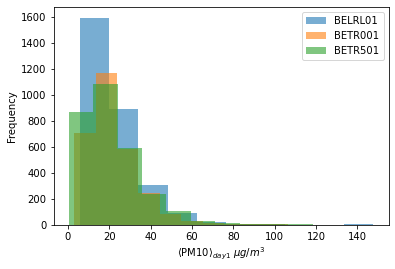

In [325]:
for stat,df in df_dict.items():
    plt.hist(df["PM10"], alpha=0.6, label=stat)
plt.legend(loc='upper right')
plt.ylabel("Frequency")
plt.xlabel(r"$\langle$PM10$\rangle_{day 1}$ $\mu g / m^3$")
plt.show()
plt.savefig("fname", dpi)